In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

import myTestingPlot as myPlotT
import myDatasetPlot as myPlotD
import myDatasetParse as myParse
import myWriteFile as myWrite

## Parse datasets

In [2]:
tmp1, tmp2 = myParse.loadDataFromTxt('augmented_vowels')

# Shuffle the matrix of all letters
vowels_data = np.zeros(tmp1.shape)
vowels_label = np.empty(tmp2.shape, dtype=str) 

index_ary = list(range(0, tmp1.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, tmp1.shape[0]):
    vowels_data[i,:] = tmp1[index_ary[i],:]
    vowels_label[i]  = tmp2[index_ary[i]]
    
# Separate in 60% and 40% for training the TF model and the OL model
sep = int((vowels_data.shape[0])*0.30)

print('\n**** OL data')
OL_data  = vowels_data[:sep, :]
OL_label = vowels_label[:sep]
OL_data_train_vow, OL_label_train_vow, OL_data_test_vow, OL_label_test_vow = myParse.parseTrainValid(OL_data, OL_label)


print('\n**** TF data')
TF_data  = vowels_data[sep:, :]
TF_label = vowels_label[sep:]
TF_data_train, TF_label_train, TF_data_test, TF_label_test = myParse.parseTrainValid(TF_data, TF_label)


******* Dataset for letter ['A' 'E' 'I' 'O' 'U']

Raw shape        -> (180000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 900
1 Sample is long -> 200


**** OL data

*** Separate train-valid

Train data shape  -> (189, 600)
Train label shape -> (189,)

Test data shape   -> (80, 600)
Test label shape  -> (80,)

**** TF data

*** Separate train-valid

Train data shape  -> (441, 600)
Train label shape -> (441,)

Test data shape   -> (188, 600)
Test label shape  -> (188,)


In [3]:
B_data, B_label = myParse.loadDataFromTxt('B_dataset')
B_train_data, B_train_label, B_test_data, B_test_label = myParse.parseTrainValid(B_data, B_label)

******* Dataset for letter ['B']

Raw shape        -> (29400, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 147
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (102, 600)
Train label shape -> (102,)

Test data shape   -> (43, 600)
Test label shape  -> (43,)


In [4]:
M_data, M_label = myParse.loadDataFromTxt('M_dataset')
M_train_data, M_train_label, M_test_data, M_test_label = myParse.parseTrainValid(M_data, M_label)

******* Dataset for letter ['M']

Raw shape        -> (29000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 145
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (101, 600)
Train label shape -> (101,)

Test data shape   -> (42, 600)
Test label shape  -> (42,)


In [5]:
R_data, R_label = myParse.loadDataFromTxt('R_dataset')
R_train_data, R_train_label, R_test_data, R_test_label = myParse.parseTrainValid(R_data, R_label)

******* Dataset for letter ['R']

Raw shape        -> (29000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 145
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (101, 600)
Train label shape -> (101,)

Test data shape   -> (42, 600)
Test label shape  -> (42,)


###  Dataset of all letters

In [6]:
# Create a matrix that contains all the train data

order_data_all = OL_data_train_vow
order_data_all = np.vstack(( order_data_all, B_train_data))
order_data_all = np.vstack(( order_data_all, R_train_data))
order_data_all = np.vstack(( order_data_all, M_train_data))

order_label_all = OL_label_train_vow
order_label_all = np.hstack(( order_label_all, B_train_label))
order_label_all = np.hstack(( order_label_all, R_train_label))
order_label_all = np.hstack(( order_label_all, M_train_label))

print('\nNew dataset of ordered data has shape ' + str(order_data_all.shape))
print('New dataset of ordered label has shape' + str(order_label_all.shape))


New dataset of ordered data has shape (493, 600)
New dataset of ordered label has shape(493,)


In [7]:
# Shuffle the matrix of all letters
mixed_data_all = np.zeros(order_data_all.shape)
mixed_label_all = np.empty(order_label_all.shape, dtype=str) 

index_ary = list(range(0, order_data_all.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, order_data_all.shape[0]):
    mixed_data_all[i,:] = order_data_all[index_ary[i],:]
    mixed_label_all[i]  = order_label_all[index_ary[i]]

###  Dataset of only new letters

In [8]:
# Create a matrix that contains all the train data

order_data_new = B_train_data
order_data_new = np.vstack(( order_data_new, R_train_data))
order_data_new = np.vstack(( order_data_new, M_train_data))

order_label_new = B_train_label
order_label_new = np.hstack(( order_label_new, R_train_label))
order_label_new = np.hstack(( order_label_new, M_train_label))

print('\nNew dataset of mixed data has shape ' + str(order_data_new.shape))
print('New dataset of mixed label has shape' + str(order_label_new.shape))


New dataset of mixed data has shape (304, 600)
New dataset of mixed label has shape(304,)


In [9]:
# Shuffle the matrix of all letters
mixed_data_new = np.zeros(order_data_new.shape)
mixed_label_new = np.empty(order_label_new.shape, dtype=str) 

index_ary = list(range(0, order_data_new.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, order_data_new.shape[0]):
    mixed_data_new[i,:] = order_data_new[index_ary[i],:]
    mixed_label_new[i]  = order_label_new[index_ary[i]]

In [10]:
class Data_Container(object):
    def __init__(self):

        self.R_test_data       = R_test_data
        self.R_test_label      = R_test_label
        self.B_test_data       = B_test_data
        self.B_test_label      = B_test_label
        self.M_test_data       = M_test_data
        self.M_test_label      = M_test_label
        self.R_test_data       = R_test_data
        self.OL_data_test_vow  = OL_data_test_vow
        self.OL_label_test_vow = OL_label_test_vow
        
OL_testing_data = Data_Container()

## Define ML model

In [11]:
def lettToSoft(ary, labels):
    ret_ary = np.zeros([len(ary), len(labels)])
    
    for i in range(0, len(ary)):
        for j in range(0, len(labels)):
            if(ary[i]==labels[j]):
                ret_ary[i,j] = 1

            
    return ret_ary   

In [12]:
# Basic parameters
optimizer = 'Adam'
loss    = 'categorical_crossentropy'
metrics = ['accuracy']
vowels = ['A', 'E', 'I', 'O', 'U']

epochs = 20         # 20
batch_size = 16    # 16

In [13]:
# Model structure

# Buoni risultati con 3 layer da 300

model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape =(TF_data_train.shape[1],),name='input_layer'))
model.add(Dense(300, activation = 'relu', name='hidden1'))   # 300 ERA MOLTO BUONO
model.add(Dense(5, activation='softmax' , name = 'output_layer'))

In [14]:
model.compile(optimizer= optimizer, loss=loss, metrics=metrics) #use sparse is each letter is an integer (es a->1 b->2 c->3 ..)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 128)               76928     
_________________________________________________________________
hidden1 (Dense)              (None, 300)               38700     
_________________________________________________________________
output_layer (Dense)         (None, 5)                 1505      
Total params: 117,133
Trainable params: 117,133
Non-trainable params: 0
_________________________________________________________________


### Train

In [15]:
# Perform training
train_hist = model.fit(TF_data_train, lettToSoft(TF_label_train, vowels), epochs=epochs, batch_size=batch_size, validation_split=0.2 , verbose=2)
print('\nEvaluation:')
results = model.evaluate(TF_data_test, lettToSoft(TF_label_test, vowels), verbose=2)

Epoch 1/20
22/22 - 0s - loss: 168.9684 - accuracy: 0.4659 - val_loss: 43.2979 - val_accuracy: 0.7753
Epoch 2/20
22/22 - 0s - loss: 20.9540 - accuracy: 0.7983 - val_loss: 19.3974 - val_accuracy: 0.8315
Epoch 3/20
22/22 - 0s - loss: 10.2720 - accuracy: 0.8636 - val_loss: 16.8361 - val_accuracy: 0.8539
Epoch 4/20
22/22 - 0s - loss: 8.6522 - accuracy: 0.8778 - val_loss: 13.9545 - val_accuracy: 0.8764
Epoch 5/20
22/22 - 0s - loss: 7.1067 - accuracy: 0.8977 - val_loss: 11.4947 - val_accuracy: 0.8202
Epoch 6/20
22/22 - 0s - loss: 8.7695 - accuracy: 0.8977 - val_loss: 3.5303 - val_accuracy: 0.9438
Epoch 7/20
22/22 - 0s - loss: 3.1357 - accuracy: 0.9489 - val_loss: 12.2660 - val_accuracy: 0.8539
Epoch 8/20
22/22 - 0s - loss: 3.3566 - accuracy: 0.9176 - val_loss: 8.0429 - val_accuracy: 0.8539
Epoch 9/20
22/22 - 0s - loss: 2.4954 - accuracy: 0.9489 - val_loss: 13.8656 - val_accuracy: 0.9101
Epoch 10/20
22/22 - 0s - loss: 4.8878 - accuracy: 0.9403 - val_loss: 7.8251 - val_accuracy: 0.8989
Epoch 11

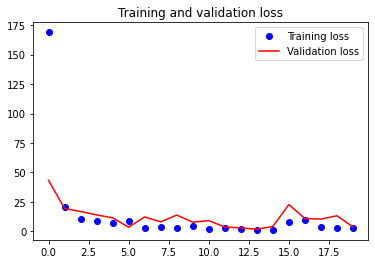

In [16]:
hist_loss = train_hist.history['loss']
hist_val_loss = train_hist.history['val_loss']
epoch_list = list(range(epochs))
plt.figure(1)
plt.plot(epoch_list, hist_loss, 'bo', label='Training loss')
plt.plot(epoch_list, hist_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test on random vowel

In [17]:
rand_n = int(random.uniform(0, TF_data_test.shape[0]))
sample_data = TF_data_test[rand_n,:].reshape(1,TF_data_test.shape[1])
sample_label = TF_label_test[rand_n]

pred = model.predict(sample_data)
print(f'True       -> {sample_label}')
print(f'Prediction -> {vowels[np.argmax(pred)]}' )

True       -> O
Prediction -> O


### Plot performance of model

In [18]:
#myPlotT.plotTest(TF_data_test, TF_label_test, model, vowels)

### Save model

In [19]:
def saveParams(SAVE_MODEL_PATH, model):
    
    new_file = open(SAVE_MODEL_PATH + '/params.txt', "w")

    new_file.write("PARAMETERS SAVED FROM THE TRAINING")
    new_file.write("\n Batch size: " + str(batch_size))
    new_file.write("\n Epochs: " + str(epochs))
    new_file.write("\n Validation split: " + str(0.2))
    new_file.write("\n Metrics: " + str(metrics))
    new_file.write("\n Optimizer: " + optimizer)
    new_file.write("\n Loss: " + loss + "\n\n")

    model.summary(print_fn=lambda x: new_file.write(x + '\n'))

In [20]:
SAVE_MODEL_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/model/"
model.save(SAVE_MODEL_PATH + "model.h5")
saveParams(SAVE_MODEL_PATH, model)

#  ------------------------------------------------------------------------

# TinyOL

### Functions

In [21]:
class Custom_Layer(object):
    def __init__(self, model):

        # Related to the layer
        self.ML_frozen = keras.models.Sequential(model.layers[:-1])
        self.ML_frozen.compile()
        self.W = np.array(model.layers[-1].get_weights()[0])
        self.b = np.array(model.layers[-1].get_weights()[1])
        self.label = ['A', 'E', 'I', 'O', 'U']
        self.l_rate = 0
        
        self.width = self.W.shape[0]
        
        
        # Related to the results fo the model
        self.confusion_matrix = []
        self.correct_ary = []
        self.mistake_ary = []
        self.totals_ary = []
        
        self.macro_avrg_precision = 0
        self.macro_avrg_recall = 0
        self.macro_avrg_F1score = 0
        
        self.title = ''
        self.filename = ''
        
        

    def predict(self, x):
        mat_prod = np.matmul(x, self.W) + self.b
        return tf.nn.softmax(mat_prod)      

In [22]:
def checkNewClass(model, y_true, y_true_soft, i, gauss):
    
    # Check if letter is new
    found = 0
    for k in range(0, len(model.label)):
        if (y_true[i] == model.label[k]):
            found = 1

    # If first time seeing this letter
    if (found == 0):

        model.label.append(y_true[i])   # Add new letter to label
        print(f'\n\n    New letter detected -> letter \033[1m{y_true[i]}\033[0m \n')
    
        if(gauss==0):
            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))
        elif(gauss==1):
            gaussW = np.zeros([model.width,1])
            for i in range(0,model.width):
                gaussW[i,0] = random.gauss(0, 0.01)
            gaussB = random.gauss(0, 0.01)
            model.W = np.hstack((model.W, gaussW))
            model.b = np.hstack((model.b, gaussB))
        elif(gauss==2):  # sporcariaper far funzionare LWF
            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))
            
                   
        print(f'    Now W is -> {model.W.shape}              and b is -> {model.b.shape}\n\n')

        y_true_soft = lettToSoft(y_true, model.label)
                
    return y_true_soft

### OL

In [23]:
def trainOneEpoch_OL(model, x, y_true):
    
    print('**********************************\nPerforming training with OL METHOD - STOCHASTICH\n')
   
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)  # Transform the true label letters in softmax
        
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        # PPREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])        
          
        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [24]:
def trainOneEpoch_OL_miniBatch(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with OL METHOD - MINI BATCH\n')
    
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    y_true_soft = lettToSoft(y_true, model.label)     # Transform the true label letters in softmax array
        
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        if(i%batch_size==0):
                model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
                model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]

                sum_gradW = np.zeros([h, 8])  #reset each batch  
                sum_gradB = np.zeros([1, 8])  #reset each batch   
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,h): 
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:w] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:w] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
            model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2

In [25]:
  def trainOneEpoch_OL_v2(model, x, y_true):
    
    print('**********************************\nPerforming training with CWR METHOD - STOCASTICH \n')
    
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax
            
    # Cycle over every sample
    for i in range(0, tot_samples):
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 1)    # Check if letter is new
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]  

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,5:] = model.W[j,5:]-dW[5:]

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b[5:] = model.b[5:]-db[5:]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [55]:
def trainOneEpoch_OL_v2_miniBatch(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with CWR - MINI BATCH \n ')  

    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    # Transform the true label letters in softmax array
    y_true_soft = lettToSoft(y_true, model.label)
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0) # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # If beginning of batch
        if(i%batch_size==0):
                model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
                model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
                sum_gradW = np.zeros([h, 8])  # reset
                sum_gradB = np.zeros([1, 8])  # reset
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,h):  
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:tmp.shape[0]] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:cost.shape[0]] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
            model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### LWF

In [103]:
def trainOneEpochOL_LWF(model, x, y_true):
    
    print('**********************************\nPerforming training with LWF - STOCHASTIC\n ') 
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    y_LWF = np.zeros([1, 8])    # Define container for LWF

    # DEFINE ORIGINAL WEIGHTS AND BIASES
    LWF_w = model.W
    LWF_b = model.b
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax
         
    # Cycle over every sample
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 2)   # Check if letter is new
        
        w = model.W.shape[1]
        h = model.W.shape[0]
        
        # va da 1 a 0
        lam = 100/(100+cntr)    #1-i/493    #  1/(20+cntr)        #
             
        # PREDICTIONS
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])
        y_LWF[0,:5] = tf.nn.softmax(np.matmul(y_ML, LWF_w) + LWF_b)           
          
        
        # BACKPROPAGATION        
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[0,:w]

        for j in range(0,h):
            # Update weights
            deltaW_norm = np.multiply(cost_norm,1-lam)
            deltaW_LWF  = np.multiply(cost_LWF, lam)
            deltaW      = np.multiply(deltaW_norm+deltaW_LWF, y_ML[0,j])
            dW          = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db_norm = np.multiply(cost_norm, 1-lam)
        db_LWF  = np.multiply(cost_LWF, lam)
        db      = np.multiply(db_norm+db_LWF, learn_rate)
        model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [104]:
def trainOneEpochOL_LWF_v2_VECCHIO(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with LWF - MINI BATCH\n')
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)  # Transform the true label letters in softmax array
        
    # Initialize now and then reset it once every batch_size
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    LWF_w   = np.zeros([model.W.shape[0], 8]) 
    LWF_w[:model.W.shape[0], :model.W.shape[1]] = model.W
    LWF_b   = np.zeros([1, 8]) 
    LWF_b[0, :model.W.shape[1]] = model.b
    
    # Define a matrix that I can then fill with the initial inference
    y_LWF = np.zeros([ x.shape[0], 8])
    
    # For every sample in the dataset given
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # END OF BATCH
        if(i%batch_size==0):
            model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h, :w]
            model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]

            sum_gradW = np.zeros([h, 8])  # reset
            sum_gradB = np.zeros([1, 8])  # reset
            
            LWF_w[:,:w] = np.copy(model.W)
            LWF_b[0,:w] = np.copy(model.b)
                
        if(cntr<batch_size):
            lam = 0
        else:
            lam = 1-batch_size/cntr  #(cntr/493)   va da 0 a 1
        #lam = cntr/493 va  da 0 a 1
    
        # PREDICTION - Frozen + OL
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])        
        y_LWF[0,:w] = tf.nn.softmax(np.matmul(y_ML, LWF_w[:,:w]) + LWF_b[0,:w])
         
        # ---- BACKPROPAGATION | MINI BATCH + LWF
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[0,:w]
        
        tmp_d_cost_norm = np.multiply(cost_norm, 1-lam)
        tmp_d_cost_LWF  = np.multiply(cost_LWF,  lam)

        for j in range(0,h):

            # Update weights
            tmp_tot      = np.multiply(tmp_d_cost_norm+tmp_d_cost_LWF, y_ML[0,j])
            deltaW       = np.zeros([1,8])
            deltaW[0,:w] = tmp_tot 
            sum_gradW[j,:] += deltaW[0,:] 
            
            

        # Update biases  
        deltaB       = np.zeros([1,8])
        deltaB[0,:w] = tmp_d_cost_norm+tmp_d_cost_LWF
        sum_gradB += deltaB
            
        # if is last iteration , update the matrix
        if(i==tot_samples-1):
            model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h, :w]
            model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### CWR

In [58]:
def trainOneEpoch_CWR(model, x, y_true, batch_size):
        
    print('**********************************\nPerforming training CWR \n ')  

    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    TW = np.zeros([model.W.shape[0], 8])
    TB = np.zeros([1, 8])
    found_lett = np.zeros([1,8])
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax array
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0) # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        dummy = 0
        
        # If beginning of batch
        if(i%batch_size==0 and i!=0): 
            for k in range(0, w):
                if(found_lett[0,k]==0):
                    dummy = 0
                    #model.W[:,k] = np.copy(TW[:,k])
                    #model.b[k]   = np.copy(TB[0,k])
                else:
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k]  , found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
                    
            TW[:h,:w]  = np.copy(model.W)
            TB[0,:w]   = np.copy(model.b)
            found_lett = np.zeros([1,8])  # reset
        elif(i==0):
            TW = np.zeros([h, 8])         # reset  
            TB = np.zeros([1, 8])         # reset  
            found_lett = np.zeros([1,8])  # reset
                
        found_lett[0,np.argmax(y_true_soft[i,:])] += 1  # update the letter counter
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = tf.nn.softmax(np.matmul(y_ML, TW) + TB)

        # BACKPROPAGATION
        cost = y_pred[0,:w]-y_true_soft[i,:]

        # Update weights
        for j in range(0,h):
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            TW[j,:w] = TW[j,:w] - dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        TB[0,:w] = TB[0,:w]-db

        # If last iteration
        if(i==tot_samples-1):
            for k in range(5, w):
                if(found_lett[0,k]==0):
                    dummy = 0
                    #model.W[:,k] = np.copy(TW[:,k])
                    #model.b[k]   = np.copy(TB[0,k])
                else:
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k]  , found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1
        

### Create ML model (cut model)

In [59]:
ML_model = keras.models.Sequential(model.layers[:-1])
ML_model.summary()
ML_model.compile()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 128)               76928     
_________________________________________________________________
hidden1 (Dense)              (None, 300)               38700     
Total params: 115,628
Trainable params: 115,628
Non-trainable params: 0
_________________________________________________________________


In [60]:
SAVE_MODEL_CUT_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/Frozen_model/"
ML_model.save(SAVE_MODEL_CUT_PATH + "model.h5")
saveParams(SAVE_MODEL_CUT_PATH, ML_model)

# Trainings

In [61]:
num_epochs = 1
batch_size_new = 10

In [62]:
# DEFINE WHICH TRAINING AND PLOTS TO SHOW

KERAS      = 1
OL_vowels  = 0
OL         = 0
OL_mini    = 0
LWF        = 1
LWF_mini   = 1
OL_v2      = 0
OL_v2_mini = 0
CWR        = 0

### Define KERAS model

In [63]:
if(KERAS==1):
    Model_KERAS = Custom_Layer(model)
    Model_KERAS.title = 'KERAS'
    Model_KERAS.filename = 'origModel'
    Model_KERAS.label = ['A','E','I','O','U','B','R','M']
    # DO NOT PERFORM TRAINING, KEEP IT AS IT IS, IT'S THE ORIGINAL MODEL

### Train with OL only on vowels

In [64]:
if(OL_vowels==1):
    Model_OL_vowels = Custom_Layer(model)
    Model_OL_vowels.title = 'VOWELS'
    Model_OL_vowels.filename = 'trainVowels'
    Model_OL_vowels.l_rate = 0.000005
    for i in range(0, num_epochs):
        trainOneEpoch_OL(Model_OL_vowels, OL_data_train_vow, OL_label_train_vow)

### Train with OL method

In [65]:
if(OL==1):
    Model_OL_all_mixed = Custom_Layer(model)
    Model_OL_all_mixed.title = 'OL' 
    Model_OL_all_mixed.filename = 'trainOL'
    Model_OL_all_mixed.l_rate = 0.000005  
    for i in range(0, num_epochs):
        trainOneEpoch_OL(Model_OL_all_mixed, mixed_data_all, mixed_label_all)

### Train with OL + mini batch

In [66]:
if(OL_mini==1):
    Model_OL_mini = Custom_Layer(model)
    Model_OL_mini.title = 'OL + mini batch'
    Model_OL_mini.filename = 'trainOL_mini'
    Model_OL_mini.l_rate = 0.0005  #0.0005
    for i in range(0, num_epochs):
        trainOneEpoch_OL_miniBatch(Model_OL_mini, mixed_data_all, mixed_label_all, batch_size_new)

### Train with LWF

In [105]:
if(LWF==1):
    Model_LWF_1 = Custom_Layer(model)
    Model_LWF_1.title = 'LWF'
    Model_LWF_1.filename = 'trainLWF_v1'   
    Model_LWF_1.l_rate = 0.0001
    for i in range(0, num_epochs):
        trainOneEpochOL_LWF(Model_LWF_1, mixed_data_all, mixed_label_all)   

**********************************
Performing training with LWF - STOCHASTIC
 


    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.61% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 2.23% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train LWF + mini batches

In [99]:
def trainOneEpochOL_LWF_v2(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with LWF - MINI BATCH\n')
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)  # Transform the true label letters in softmax array
        
    w = model.W.shape[1]
        
    LWF_w = np.zeros([model.W.shape[0], 8]) # alocate
    LWF_b = np.zeros([1, 8]) 
    y_LWF = np.zeros([1, 8])
    
    LWF_w[:,:w] = model.W   # copy from TF
    LWF_b[0,:w] = model.b
    
    # For every sample in the dataset given
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # END OF BATCH
        if(i%batch_size==0 and i!=0):            
            LWF_w[:,:w] = np.copy(model.W)    # update the LWF w matrix
            LWF_b[0,:w] = np.copy(model.b)    # update the LWF b matrix
                
        #lam = 1/(2+cntr)
        if(cntr<batch_size):
            lam = 1
        else:
            lam = batch_size/cntr  #(cntr/493)   va da 0 a 1
    
        # PREDICTION - Frozen + OL
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])        
        y_LWF[0,:w] = tf.nn.softmax(np.matmul(y_ML, LWF_w[:,:w]) + LWF_b[0,:w])

         
        # ---- BACKPROPAGATION | MINI BATCH + LWF        
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[0,:w]
        
        lam_cost_norm = np.multiply(cost_norm, 1-lam)
        lam_cost_LWF  = np.multiply(cost_LWF,  lam)

        for j in range(0,h):

            # Update weights
            deltaW = np.multiply(lam_cost_norm+lam_cost_LWF, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW          
            
        # Update biases 
        db = np.multiply(lam_cost_norm+lam_cost_LWF, learn_rate)
        model.b = model.b-db   
                        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [100]:
if(LWF_mini==1):
    Model_LWF_2 = Custom_Layer(model)
    Model_LWF_2.title = 'LWF + mini batch'
    Model_LWF_2.filename = 'trainLWF_v2'
    Model_LWF_2.l_rate = 0.0005 
    for i in range(0, num_epochs):
        trainOneEpochOL_LWF_v2(Model_LWF_2, mixed_data_all, mixed_label_all, batch_size_new)

**********************************
Performing training with LWF - MINI BATCH



    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.61% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 2.23% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL v2 

In [70]:
if(OL_v2==1):
    Model_OL_v2 = Custom_Layer(model)
    Model_OL_v2.title = 'OL v2' 
    Model_OL_v2.filename = 'trainOL_v2'
    Model_OL_v2.l_rate = 0.0005
    for i in range(0, num_epochs):
        trainOneEpoch_OL_v2(Model_OL_v2, mixed_data_all, mixed_label_all)

### Train with OL v2 + mini batch

In [71]:
if(OL_v2_mini==1):
    Model_OL_v2_miniBatch = Custom_Layer(model)
    Model_OL_v2_miniBatch.title = 'OL v2 + mini batch'
    Model_OL_v2_miniBatch.filename = 'trainOL_v2_mini'
    Model_OL_v2_miniBatch.l_rate = 0.0007
    for i in range(0, num_epochs):
        trainOneEpoch_OL_v2_miniBatch(Model_OL_v2_miniBatch, mixed_data_all, mixed_label_all, batch_size_new)

### Train with CWR

In [72]:
if(CWR==1):
    Model_CWR = Custom_Layer(model) 
    Model_CWR.title = 'CWR'
    Model_CWR.filename = 'trainCWR'
    Model_CWR.l_rate = 0.00005
    for i in range(0, num_epochs):
        trainOneEpoch_CWR(Model_CWR, mixed_data_all, mixed_label_all, 10)
        # GOOD l rate 0.00005  - batch size 10

# SIMULATION PLOTS

### Original model

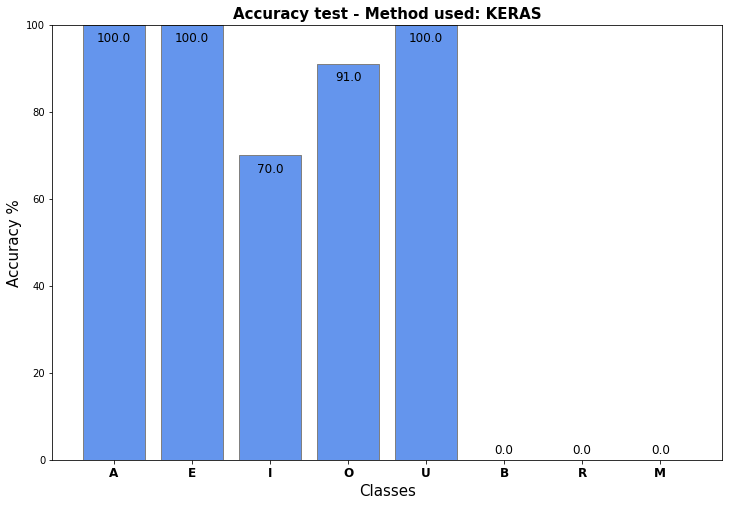

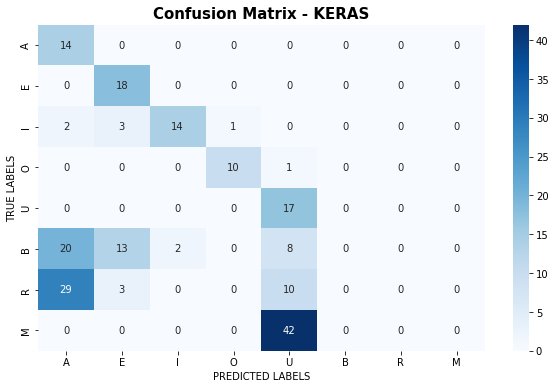

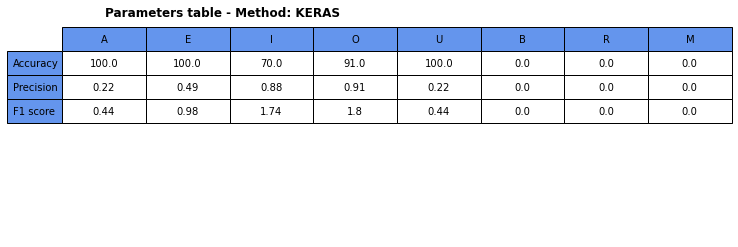

In [73]:
if(KERAS==1):
    myPlotT.testOL(Model_KERAS, OL_testing_data)
    myPlotT.plotTestOL(Model_KERAS)   
    

### Only vowels

In [74]:
if(OL_vowels==1):
    myPlotT.testOL(Model_OL_vowels, OL_testing_data)
    myPlotT.plotTestOL(Model_OL_vowels)

### OL

In [75]:
if(OL==1):
    myPlotT.testOL(Model_OL_all_mixed, OL_testing_data)
    myPlotT.plotTestOL(Model_OL_all_mixed)

### OL + mini batch

In [76]:
if(OL_mini==1):
    myPlotT.testOL(Model_OL_mini, OL_testing_data)
    myPlotT.plotTestOL(Model_OL_mini)

### LWF

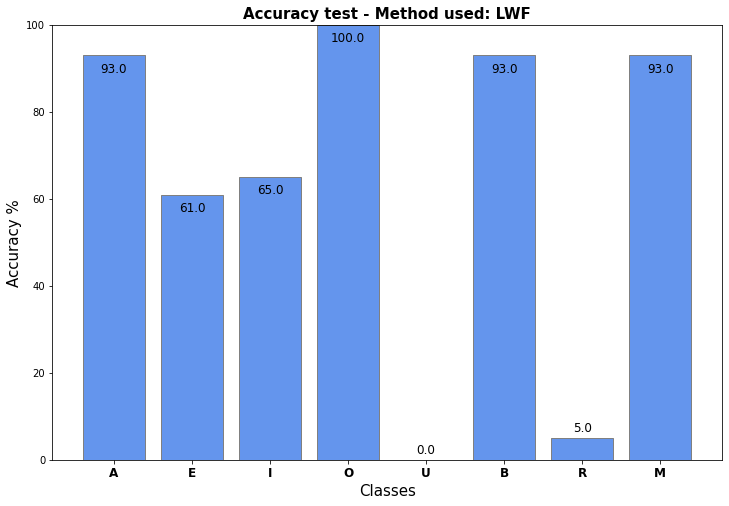

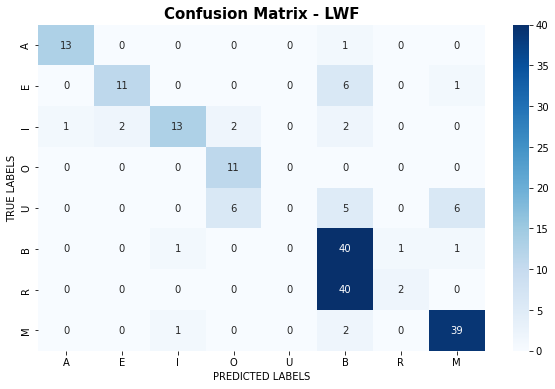

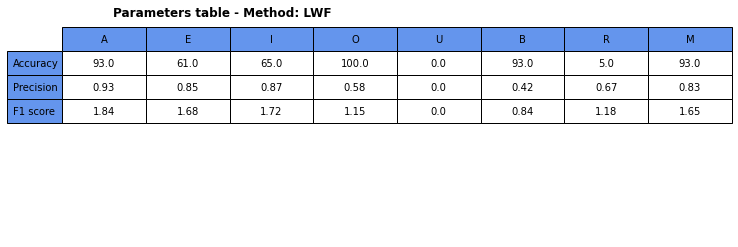

In [106]:
if(LWF==1):
    myPlotT.testOL(Model_LWF_1, OL_testing_data)
    myPlotT.plotTestOL(Model_LWF_1)

### LWF + mini batch

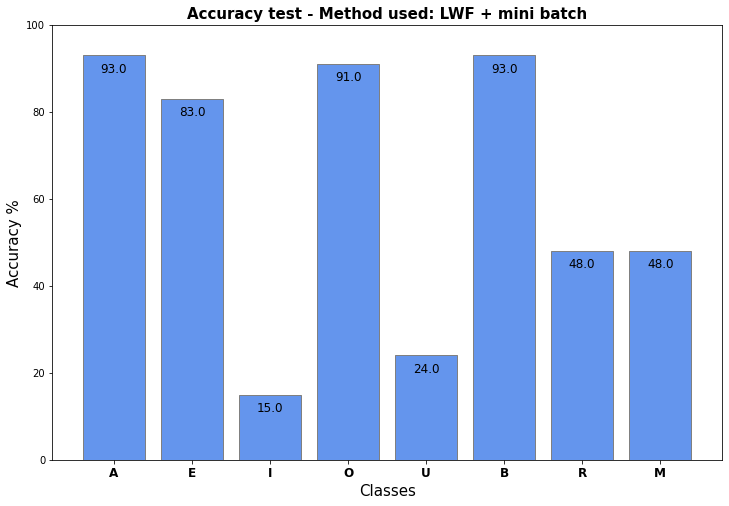

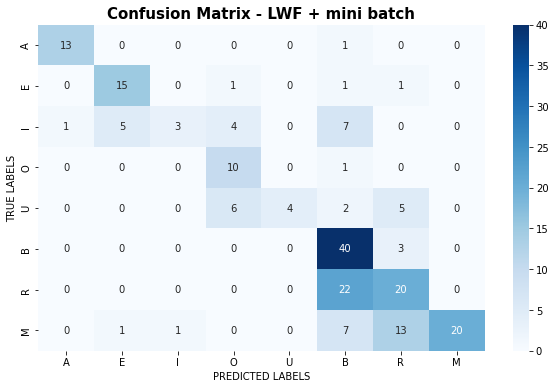

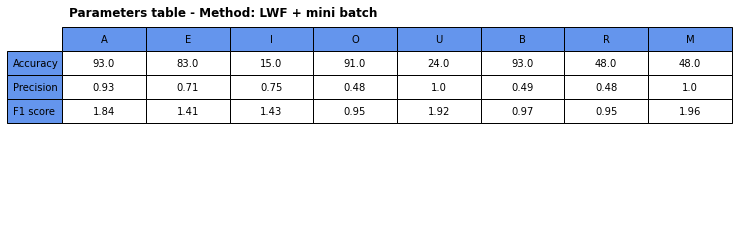

In [102]:
if(LWF_mini==1):
    myPlotT.testOL(Model_LWF_2, OL_testing_data)
    myPlotT.plotTestOL(Model_LWF_2)

### OL v2

In [79]:
if(OL_v2==1):
    myPlotT.testOL(Model_OL_v2, OL_testing_data)
    myPlotT.plotTestOL(Model_OL_v2)

### OL v2 + mini batch

In [80]:
if(OL_v2_mini==1):
    myPlotT.testOL(Model_OL_v2_miniBatch, OL_testing_data)
    myPlotT.plotTestOL(Model_OL_v2_miniBatch)

### CWR

In [81]:
if(CWR==1):
    myPlotT.testOL(Model_CWR, OL_testing_data)
    myPlotT.plotTestOL(Model_CWR)

## All plots

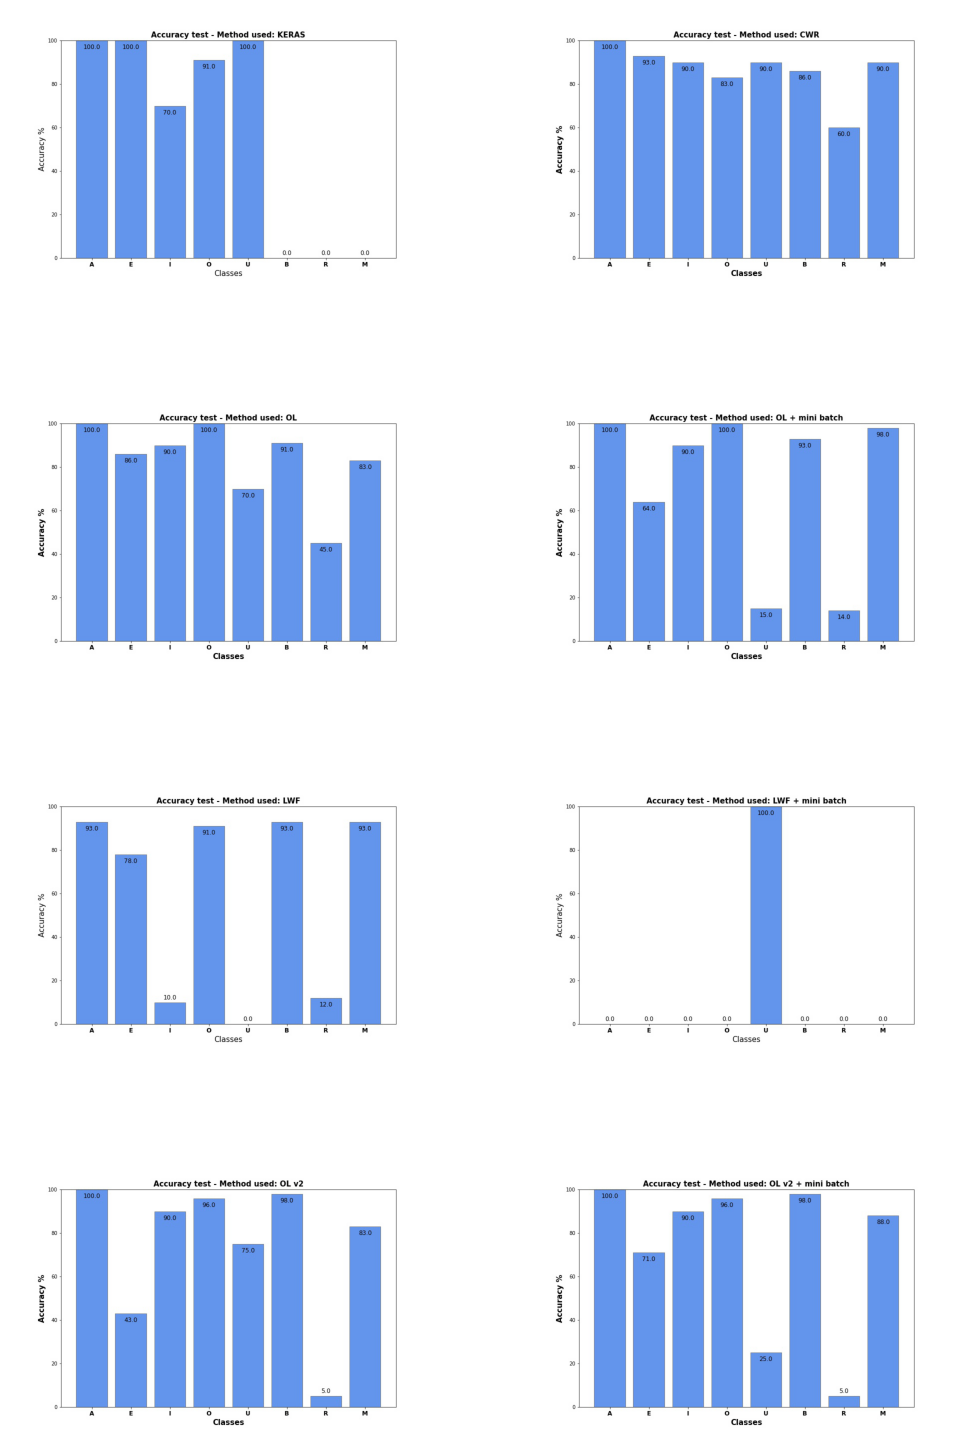

In [82]:
myPlotT.plotAllTEst()

In [83]:
myPlotT.summaryResults(Model_KERAS, Model_OL_vowels, Model_OL_all_mixed, Model_OL_mini, 
               Model_LWF_1, Model_LWF_2, Model_OL_v2, Model_OL_v2_miniBatch, Model_CWR)

NameError: name 'Model_OL_vowels' is not defined

# GENERAL PLOTS

In [ ]:
# Write down in txt files all the results across 10 or so simulations          
WRITE_SIMU_RES = 0
                
if(WRITE_SIMU_RES==1):
    myWrite.writeSimuRes('orig',      res00, res01, res02)
    myWrite.writeSimuRes('vowels',    res10, res11, res12)
    myWrite.writeSimuRes('OL',        res20, res21, res22)
    myWrite.writeSimuRes('OL_mini',   res30, res31, res32)
    myWrite.writeSimuRes('LWF',       res40, res41, res42)
    myWrite.writeSimuRes('LWF_mini',  res50, res51, res52)
    myWrite.writeSimuRes('OL_v2',     res60, res61, res62)
    myWrite.writeSimuRes('OL_v2_min', res70, res71, res72)
    myWrite.writeSimuRes('CWR',       res80, res81, res82)

In [ ]:
#myPlotD.plotSimuRes(1)


ENABLE_PLOTS = 0
if(ENABLE_PLOTS==1):


    # Plot of the pie chart of the dataset TF e OL
    myPlotD.plotDatasetStructure(TF_data_train,TF_data_test,
                                 OL_data_train_vow,OL_data_test_vow,
                                 B_train_data,B_test_data,
                                 R_train_data,R_test_data,
                                 M_train_data,M_test_data)

    # Plot of the pie chart of the dataset OL
    myPlotD.plotDatasetOL(OL_data_train_vow,OL_data_test_vow,
                          B_train_data,B_test_data,
                          R_train_data,R_test_data,
                          M_train_data,M_test_data)

    # Plot of the pie chart of the dataset TF
    myPlotD.plotDatasetTF(TF_data_train,TF_data_test)














### ----------------------------------------------------------------------------------------------------------

# Scripts for generating libraries for the STM code

In [ ]:
myWrite.writeLastLayer(model)



WRITE_STM_FILES = 0

#if(WRITE_STM_FILES==0):
#    myWrite.writeSampleB()
#    myWrite.writeSampleMix()
#    myWrite.writeSampleVowels()